### Experiments with entropy, information gain, and decision trees.

Iris fact of the day: Iris setosa's root contains a toxin that was used by the Aleut tribe in Alaska to make poisonous arrowheads.

In [24]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [25]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [26]:
train_data[0]

array([5.8, 2.8, 5.1, 2.4])

In [27]:
# Define a function that applies a threshold to turn real valued iris features into 0/1 features.
# 0 will mean "short" and 1 will mean "long".
def binarize_iris(data, thresholds=[6.0, 3.0, 2.5, 1.0]):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold  to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Create new binarized training and test data
binarized_train_data = binarize_iris(train_data)
binarized_test_data = binarize_iris(test_data)

In [28]:
binarized_train_data[0]

array([0., 0., 1., 1.])

Let's start by defining a function that computes the entropy of a distribution. Remember that entropy is a measure of uncertainty. It is maximized when the distribution is uniform.

In [29]:
def entropy(distribution):
    h = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: logprob = np.log2(probability)
        h -= probability * logprob
    return h

In [30]:
# Show a plot of the entropy, H(X), of a Bernoulli random variable X.
p_values = np.linspace(0, 1, 50)
p_values

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [31]:
entropies = [entropy([p, 1-p]) for p in p_values]
entropies

[0.0,
 0.14372616993938178,
 0.2460225782203316,
 0.3322866302216151,
 0.40790598013897633,
 0.47543164626872064,
 0.5363596511250623,
 0.5916727785823273,
 0.6420642892306891,
 0.6880476235340796,
 0.7300166301457938,
 0.7682814090975241,
 0.8030909760146978,
 0.8346482851813828,
 0.863120568566631,
 0.8886466698980792,
 0.9113423759758416,
 0.9313043685793763,
 0.9486131982385806,
 0.9633355456726841,
 0.9755259511264972,
 0.9852281360342516,
 0.9924760039430818,
 0.997294381646235,
 0.999699542856517,
 0.999699542856517,
 0.997294381646235,
 0.992476003943082,
 0.9852281360342516,
 0.9755259511264971,
 0.9633355456726842,
 0.9486131982385806,
 0.9313043685793763,
 0.9113423759758417,
 0.8886466698980793,
 0.8631205685666311,
 0.834648285181383,
 0.8030909760146978,
 0.7682814090975241,
 0.730016630145794,
 0.6880476235340798,
 0.6420642892306894,
 0.5916727785823275,
 0.5363596511250625,
 0.47543164626872103,
 0.40790598013897666,
 0.3322866302216154,
 0.24602257822033174,
 0.143726

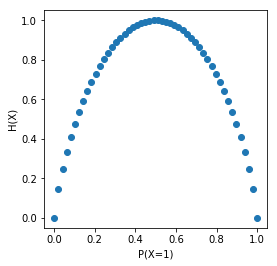

In [32]:
plt.figure(figsize=(4,4))
plt.plot(p_values, entropies, 'o')
plt.xlabel('P(X=1)')
plt.ylabel('H(X)')
print

We are interested in the entropy of our distribution over labels. You may recall that the distribution in the training data is nearly uniform.

In [33]:
def get_label_distribution(labels):
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(iris.target_names))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    return label_probs

In [34]:
label_probs = get_label_distribution(train_labels)
print 'Label distribution', label_probs

# Compare the label entropy to a uniform distribution.
print 'Label entropy:', entropy(label_probs)
print 'Uniform entropy:', entropy([1./3, 1./3, 1./3])

Label distribution [0.31 0.33 0.36]
Label entropy: 1.5822322736472714
Uniform entropy: 1.584962500721156


Now let's figure out which feature provides the greatest information gain. To do this, we need to look at the entropy of each subset of the labels after splitting on each feature.

In [35]:
# A function that computes information gain given these inputs:
#   data: an array of featurized examples
#   labels: an array of labels corresponding to the the data
#   feature: the feature to use to split the data
#   threshold: the feature value to use to split the data (the default threshold is good for binary features)
def information_gain(data, labels, feature, threshold=0):
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_label_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold: subset1.append(label)
        else: subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_label_distribution(subset0))
    subset1_entropy = entropy(get_label_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

for feature in range(binarized_train_data.shape[1]):
    ig = information_gain(binarized_train_data, train_labels, feature)
    print '%d %.3f %s' %(feature, ig, iris.feature_names[feature])

0 0.406 sepal length (cm)
1 0.216 sepal width (cm)
2 0.893 petal length (cm)
3 0.780 petal width (cm)


According to the information gain metric, petal length is the most useful feature, followed by petal width. Let's confirm that this agrees with the sklearn decision tree implementation. Actually, sklearn doesn't expose the information gain values. Instead, it stores the a distribution of "feature importances", which reflects the value of each feature in the full decision tree. Let's train a decision tree with max_depth=1 so it will only choose a single feature. Let's also get the test accuracy with this "decision stump".

In [36]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

In [37]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(binarized_train_data, train_labels)
print 'Using a decision stump -- a tree with depth 1:'
print 'Feature importances:', dt.feature_importances_
print 'Accuracy:', dt.score(binarized_test_data, test_labels)

Using a decision stump -- a tree with depth 1:
Feature importances: [0.09092576 0.0050933  0.89011686 0.01386408]
Accuracy: 0.82


In [38]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=1)
dt.fit(binarized_train_data, train_labels)
print 'Using a decision stump -- a tree with depth 1:'
print 'Feature importances:', dt.feature_importances_
print 'Accuracy:', dt.score(binarized_test_data, test_labels)

Using a decision stump -- a tree with depth 1:
Feature importances: [0. 0. 1. 0.]
Accuracy: 0.66


We've been using the binarized version of the iris features. Recall that we simply chose thresholds for each feature by inspecting feature histograms. Let's use information gain as a metric to choose a best feature and a best threshold.

In [39]:
def try_features_and_thresholds(data, labels):
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 100)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_ig = 0
        for threshold in thresholds:
            ig = information_gain(data, labels, feature, threshold)
            if ig > best_ig:
                best_ig = ig
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        print '%d %.3f %.3f %s' %(feature, best_threshold, best_ig, iris.feature_names[feature])
        
try_features_and_thresholds(train_data, train_labels)

0 5.708 0.525 sepal length (cm)
1 3.309 0.311 sepal width (cm)
2 1.910 0.893 petal length (cm)
3 0.609 0.893 petal width (cm)


It looks like when we binarized our data, we didn't choose the thresholds that maximized information gain for 3 of 4 features. Let's try training actual decision trees (as opposed to stumps) with the original (non-binarized) data. You may need to install GraphViz before exporting the tree.

In [40]:
help(pydot.graph_from_dot_data)

Help on function graph_from_dot_data in module pydot:

graph_from_dot_data(s)
    Load graphs from DOT description in string `s`.
    
    @param s: string in [DOT language](
        https://en.wikipedia.org/wiki/DOT_(graph_description_language))
    
    @return: Graphs that result from parsing.
    @rtype: `list` of `pydot.Dot`



In [41]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dt.fit(train_data, train_labels)
print 'Accuracy:', dt.score(test_data, test_labels)

Accuracy: 0.96


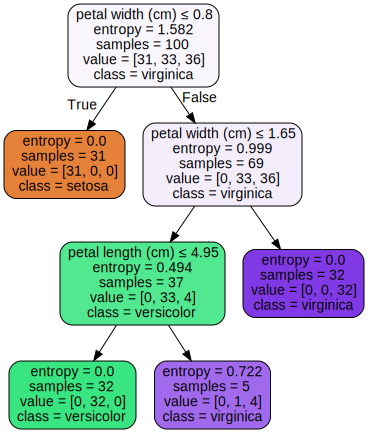

In [45]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

If you successfully output the tree, you should be able to see it here. The first split perfectly partitions the setosas because they have very narrow petals. The next split identifies a pure subset of virginicas that have wide petals. Of the remaining medium-width petal examples, those with shorter petals are versicolors, but the split is not perfect. At this point, we stop splitting because we don't have enough samples to be convinced that further splitting would generalize well.

Note, though, that his depth 3 tree gets 96% accuracy on the test data. So does a depth 2 tree (try it!). Tree pruning, which is not implemented in sklearn, can be useful for choosing a depth that generalizes well.